<a href="https://colab.research.google.com/github/elliwadler/image_classification/blob/main/cat_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bildklassifikation - 😺 vs. 🐶**

## Bibliotheken importieren


In [1]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import gdown
import random
import shutil

## Ressourcen laden

Der Code lädt einen **Datensatz** mit Hund- und Katzenbildern als ZIP-Datei herunter und extrahiert ihn in zwei Ordner, "train" und "validation", die für das Training und die Validierung des **CNN-Modells** (Convolutional Neural Networks) zur Klassifikation von Hund- und Katzenbildern verwendet werden.

In [2]:
# Download the dataset zip file
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
filename = "cats_and_dogs_filtered.zip"
urllib.request.urlretrieve(url, filename)

# Extract the zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
print("Number of images in test/cats:",  len(os.listdir('cats_and_dogs_filtered/test/cats')))
print("Number of images in test/dogs:",  len(os.listdir('cats_and_dogs_filtered/test/dogs')))

print("Number of images in validation/cats:",  len(os.listdir('cats_and_dogs_filtered/validation/cats')))
print("Number of images in validation/dogs:",  len(os.listdir('cats_and_dogs_filtered/validation/dogs')))

Number of images in test/cats: 300
Number of images in test/dogs: 300
Number of images in validation/cats: 200
Number of images in validation/dogs: 200
Number of images in train/cats: 1000
Number of images in train/dogs: 1000


## Vorbereitung der Daten 

Um die Daten für das Modell Vorzubereiten wird die **ImageDataGenerator-Klasse** aus der Keras-API verwendet. In dieser werden Datenaugmentierungstechniken wie Drehung, Zuschneiden oder Spiegeln definiert um sie auf die Bilder anzuwenden.

Anschließend wird mit der **flow_from_directory()-Methode** ein **Generator-Objekt** erzeugt, das später an das Modell übergeben wird. Dabei werden unter anderem das Verzeichnis aus dem die Bilder geladen werden, die Bildgröße, die Batch-Größe und die Label-Art (in diesem Fall binary, also entweder Hund oder Katze) definiert.


In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    # 10% of the training images will be used for validation
    validation_split=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
        'cats_and_dogs_filtered/train',
        target_size=(150, 150),
        batch_size=20,
        subset='training',
        class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
        'cats_and_dogs_filtered/train',
        target_size=(150, 150),
        batch_size=20,
        subset='validation',
        class_mode='binary')

# Images for Testing
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_directory(
        'cats_and_dogs_filtered/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


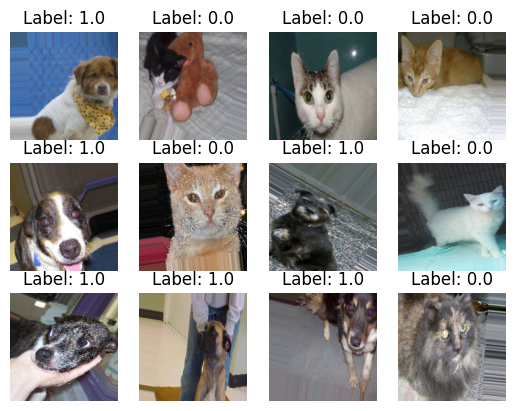

In [6]:
#Print some pictures from the train_generator
images, labels = next(train_generator)
fig, axes = plt.subplots(3, 4)
axes = axes.ravel()
for i in range(12):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title('Label: {}'.format(labels[i]))
plt.show()

## *Beispiel Augementierung eines Bildes*

Hier wird die ImageDataGenerator-Instanz **train_datagen** verwendet um die Argumentation eines Beispielbildes zu veranschaulichen. 





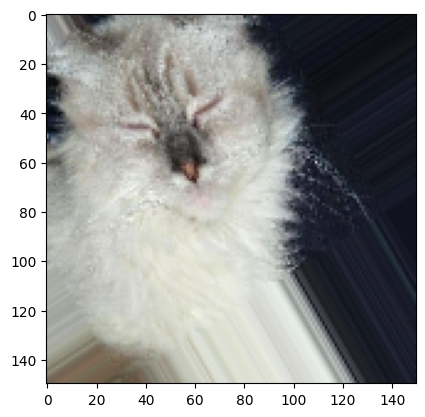

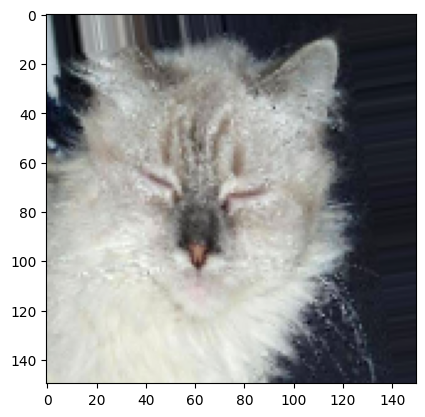

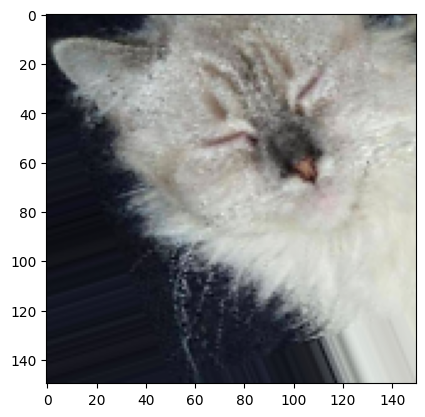

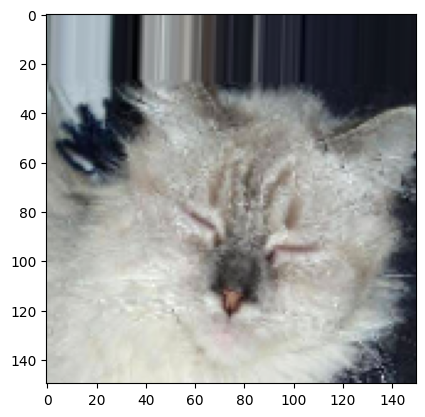

In [7]:
# get all files from the train/cat directory
fnames = [os.path.join('cats_and_dogs_filtered/train/cats', fname) for
  fname in os.listdir('cats_and_dogs_filtered/train/cats')]

# get one picture
img_path = fnames[6]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

# plot the result
i=0
for batch in train_datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break
plt.show()

## Definition des Modells

In Keras ist das **Sequential-Modell** eine Möglichkeit, um Schichten eines neuronalen Netzwerks aufeinander zu stapeln. Das bedeutet, dass die Ausgabe einer Schicht direkt an die nächste Schicht weitergegeben wird. Ein Sequential-Modell ist somit eine lineare Schichtfolge, bei der jede Schicht genau eine Eingabe und eine Ausgabe hat. Dies ist die einfachste Art, ein neuronales Netzwerk in Keras zu definieren. Die einzelnen Schichtarten werden in der **README ausführlich** erklärt!

Im nächsten Schritt wird der **Kompilierungsschritt** des Modells konfiguriert. Auf die einzelnen Werte wird wieder in der README eingeganen. 




In [27]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.15),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer= tf.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# shows each layer
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 17, 17, 128)     

## Trainieren des Modells

In diesem Code-Abschnitt wird das Modell mit den Trainingsdaten **trainiert** und dabei eine **Validierung** anhand der Validierungsdaten durchgeführt. Die Trainingsdaten und die Validierungsdaten wurden zuvor als Daten-Generator mit der Klasse **ImageDataGenerator** erstellt und werden nun als **Argumente** an die fit-Methode des Modells übergeben.

**Parameter:**

**steps_per_epoch**: gibt die Anzahl der Schritte pro Epoche an, d.h. die Anzahl der Batches, die pro Epoche durchlaufen werden sollen. 

**epochs:** gibt die Anzahl der Epochen an, die das Modell trainiert werden soll. 

**validation_steps:**  Anzahl der Schritte (Batches), die pro Validierungs-Epoche durchlaufen werden sollen. 

Die fit-Methode führt das Training des Modells durch und gibt ein **history-Objekt zurück**, das die Informationen über die Trainingsgenauigkeit, Trainingsverlust, Validierungsgenauigkeit und Validierungsverlust in jeder Epoche enthält.

**Da das Trainieren das Modells den heutigen Zeitraum sprengen würde werden wir das ein zuvor von mir trainiertes Modell in den weiteren Schritten verwenden**!

In [30]:
'''history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=70,
      validation_data=validation_generator,
      validation_steps=len(validation_generator)) '''


# load pretrained model
gdown.download_folder('https://drive.google.com/drive/folders/1MPrC5o7rI8_EYEZ6TLOWsWes44JKk-aD?usp=sharing')

Retrieving folder list


Processing file 1nAudCTyHuYbRz2OVgTXrs_Q3IlxeNY_j cats_dogs_classifier_80%.h5
Processing file 1-75fLZnJTY6hZ73njcZcIxeJRGAzwkI9 cats_dogs_classifier_82%.h5
Processing file 1-2L7gC6AgzBoKHlBbpGhZ82PlI_n6Wza model.zip
Processing file 1-C0riND-ldiGV6ecyYmZThenI1A1958V train_history_80%.csv
Processing file 1-CU0iYDbc1CmJWY3GCopAl81j4WZzfsB train_history_82%.csv
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1nAudCTyHuYbRz2OVgTXrs_Q3IlxeNY_j
To: /content/Assets_Modell/cats_dogs_classifier_80%.h5
100%|██████████| 27.7M/27.7M [00:00<00:00, 137MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-75fLZnJTY6hZ73njcZcIxeJRGAzwkI9
To: /content/Assets_Modell/cats_dogs_classifier_82%.h5
100%|██████████| 27.7M/27.7M [00:00<00:00, 99.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-2L7gC6AgzBoKHlBbpGhZ82PlI_n6Wza
To: /content/Assets_Modell/model.zip
100%|██████████| 25.6M/25.6M [00:00<00:00, 122MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-C0riND-ldiGV6ecyYmZThenI1A1958V
To: /content/Assets_Modell/train_history_80%.csv
100%|██████████| 7.60k/7.60k [00:00<00:00, 18.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-CU0iYDbc1CmJWY3GCopAl81j4WZzfsB
To: /content/Assets_Modell/train_history_82%.csv
100%|██████████| 11.4k/11.4k [00:00<00:00, 13.8MB/s

['/content/Assets_Modell/cats_dogs_classifier_80%.h5',
 '/content/Assets_Modell/cats_dogs_classifier_82%.h5',
 '/content/Assets_Modell/model.zip',
 '/content/Assets_Modell/train_history_80%.csv',
 '/content/Assets_Modell/train_history_82%.csv']

## Validierung des Modells

50/50 [==============================] - 5s 87ms/step - loss: 1.7112 - acc: 0.5000
Test accuracy: 0.5


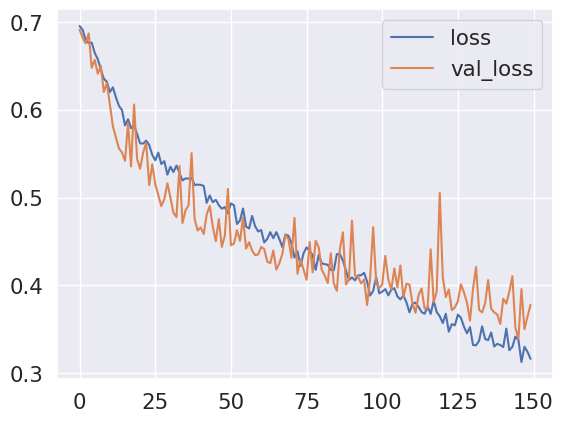

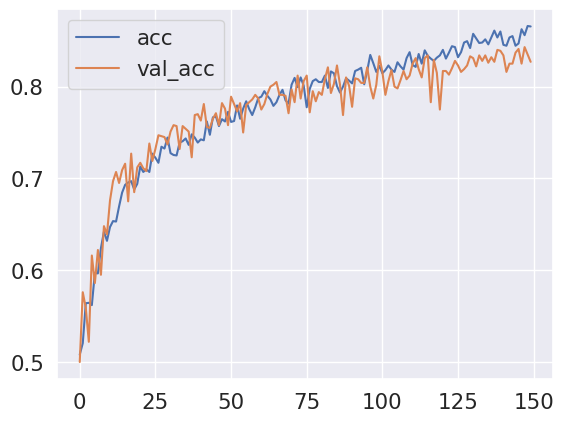

In [34]:
history_df = pd.read_csv('Assets_Modell/train_history_82%.csv')

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['acc', 'val_acc']].plot()


test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('Test accuracy:', test_acc)

50/50 [==============================] - 4s 70ms/step


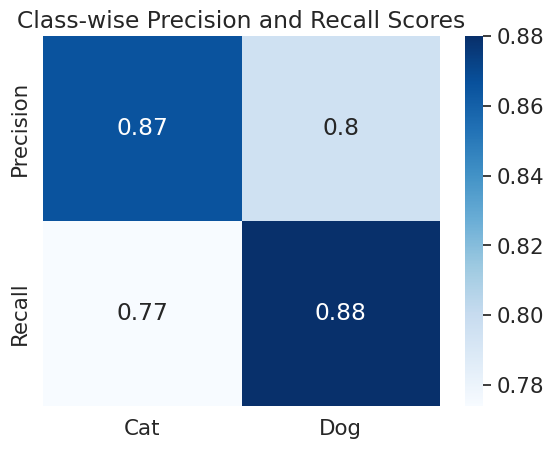

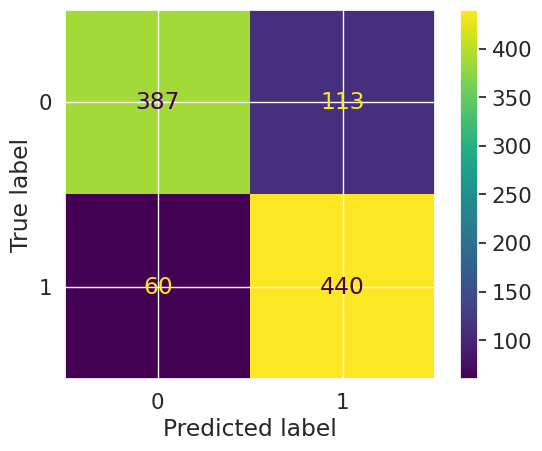

In [39]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

model = tf.keras.models.load_model('Assets_Modell/cats_dogs_classifier_82%.h5')

# Get the predicted classes for the test data
y_pred_prob = model.predict(test_generator)
y_pred = np.round(y_pred_prob)

# Get the true classes for the test data
y_true = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate precision and recall scores for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

# Create a heatmap plot of class-wise precision and recall scores
sns.set(font_scale=1.4)
sns.heatmap([precision, recall], annot=True, cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Precision', 'Recall'])
plt.title('Class-wise Precision and Recall Scores')
plt.show()

cm_display = ConfusionMatrixDisplay(cm).plot()

1/1 [==============================] - 0s 142ms/step


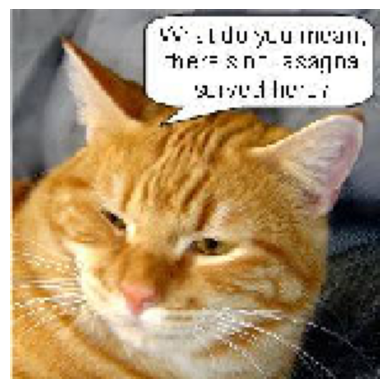

The image is a cat with a probability of 1.02%


In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import load_model


# Load the saved model
model = tf.keras.models.load_model('Assets_Modell/cats_dogs_classifier_82%.h5')

# Load the image and resize to the target size
img_path = 'cats_and_dogs_filtered/validation/cats/cat.2013.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# Convert the image to a numpy array and normalize
img_array = image.img_to_array(img)
img_array /= 255.

# Expand the dimensions of the image array to match the model input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict the class of the image
pred = model.predict(img_array)
pred_probability = pred[0][0]

# Print the image
fig, ax = plt.subplots()
img = ax.imshow(img)
ax.axis('off')
ax.grid(False)
plt.show()

if pred[0][0] > 0.5:
    print("The image is a dog with a probability of {:.2f}%".format(pred_probability * 100))
else:
    print("The image is a cat with a probability of {:.2f}%".format(pred_probability * 100))

## Nur für mich - speichern und upload des Modells !!

In [15]:
import pandas as pd

history_df = pd.DataFrame(model.history.history)
history_df.to_csv('train_history_82%.csv', index=False)
model.save('cats_dogs_classifier_82%.h5')

In [16]:
from google.colab import drive
import shutil
import zipfile

drive.mount('/content/drive')
with zipfile.ZipFile('model.zip', 'w',
                     compression=zipfile.ZIP_DEFLATED,
                     compresslevel=9) as zf:
    zf.write('/content/cats_dogs_classifier_82%.h5', arcname='cats_dogs_classifier_82%.h5')

shutil.copy("/content/cats_dogs_classifier_82%.h5","/content/drive/MyDrive/MachineLearning")

Mounted at /content/drive


'/content/drive/MyDrive/MachineLearning'

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 14.9 MB/s eta 0:00:00


In [ ]:
print(1)

In [ ]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=150, step=32),
                                  kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                                  activation='relu', input_shape=(150, 150, 3)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=150, step=32),
                                  kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                                  activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=150, step=32),
                                  kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
                                  activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=hp.Int('conv_4_filter', min_value=32, max_value=150, step=32),
                                  kernel_size=hp.Choice('conv_4_kernel', values=[3, 5]),
                                  activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout))

    model.add(keras.layers.Flatten())

    hp_dropout1 = hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout1))

    model.add(keras.layers.Dense(units=hp.Int('dense_1_units', min_value=32, max_value=512, step=32),
                                  activation='relu'))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    return model

In [ ]:
tuner = keras_tuner.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='round_3'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_generator, validation_data=validation_generator, callbacks=[stop_early])

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(150, 150, 3))
best_model.summary()